In [1]:
import numpy as np
from keras.layers import Input, MaxPool2D, Conv2D
from keras.layers.convolutional import Convolution2D
from keras.models import Model
import math
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def create_edge_kernel(left_color, right_color, angle, kernel_size = 7, dmz_size=0.0) -> np.ndarray:
    angle = angle % (2 * math.pi)
    if angle > math.pi / 2 and angle <= (3 * math.pi) / 2:
        return create_edge_kernel(right_color, left_color, angle - math.pi, kernel_size, dmz_size)
    assert kernel_size % 2 == 1
    assert len(right_color) == len(left_color)
    center = kernel_size // 2
    kernel = np.zeros(shape=(kernel_size, kernel_size, len(right_color)), dtype=np.float32)
    ratio = math.tan(angle)
    dmz = abs(ratio * dmz_size)
    for y, vy in enumerate(kernel):
        for x, v in enumerate(vy):
            cur_x = x - center
            cur_y = y - center
            if ratio * cur_x + dmz < cur_y - dmz_size:
                v[:] = right_color[:]
            elif ratio * cur_x - dmz > cur_y + dmz_size:
                v[:] = left_color[:]
    return kernel

In [3]:
fl_input_filters = 3
fl_kernel_size = 3
fl_filter_count = 8
fl_angle_increment = math.pi * 2 / fl_filter_count
first_layer_kernel = np.zeros(shape=(fl_kernel_size, fl_kernel_size, fl_input_filters, fl_filter_count))
for i in range(fl_filter_count):
    first_layer_kernel[:,:,:,i] = create_edge_kernel([1,1,-2], 
                                                     [-1,-1,-1], 
                                                     i * fl_angle_increment,
                                                     fl_kernel_size,
                                                     0.3
                                                    )
first_layer_bias = np.zeros(shape=fl_filter_count)

In [4]:
inp = Input(shape=(None,None,fl_input_filters))
output = Convolution2D(fl_filter_count, 
                       fl_kernel_size, 
                       fl_kernel_size, 
                       border_mode='same', 
                       init='normal',
                       bias=True,
                       activation='relu')(inp)
model_network = Model(input=inp, output=output)

model_network.layers[1].set_weights((first_layer_kernel, first_layer_bias))

W0722 11:07:05.563291 139752315451200 deprecation_wrapper.py:119] From /home/nicolas/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0722 11:07:05.572931 139752315451200 deprecation_wrapper.py:119] From /home/nicolas/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/home/nicolas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), activation="relu", padding="same", kernel_initializer="normal", use_bias=True)`
  
W0722 11:07:05.575195 139752315451200 deprecation_wrapper.py:119] From /home/nicolas/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

/home/nicolas/.local/

(500, 400, 3)


True

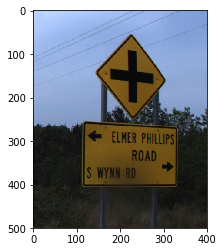

In [21]:
im = cv2.imread("test.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = im[100:600, 700:1100, :]
# im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
print(im.shape)
plt.imshow(im)
cv2.imwrite("base_image.jpg", cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

In [13]:
input_im = im.reshape((1,) + im.shape)
results = model_network.predict(input_im)
print(results.shape)

(1, 500, 400, 8)


W0722 11:18:06.325763 139752315451200 image.py:663] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


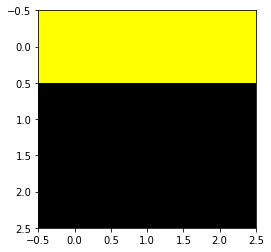

W0722 11:18:06.396518 139752315451200 image.py:663] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


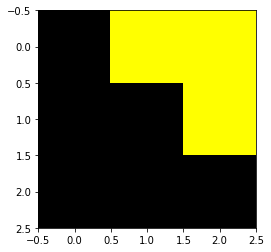

W0722 11:18:06.528359 139752315451200 image.py:663] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


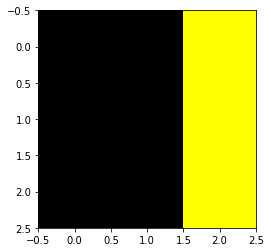

W0722 11:18:06.607273 139752315451200 image.py:663] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


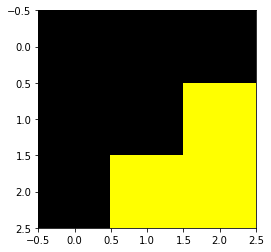

W0722 11:18:06.671914 139752315451200 image.py:663] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


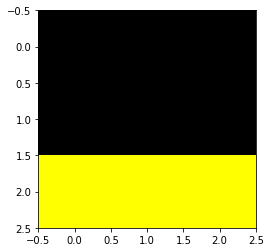

W0722 11:18:06.738642 139752315451200 image.py:663] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


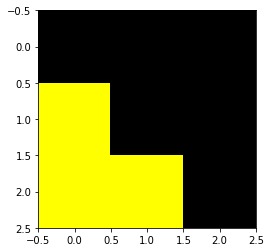

W0722 11:18:06.809643 139752315451200 image.py:663] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


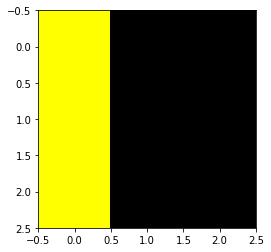

W0722 11:18:06.883570 139752315451200 image.py:663] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


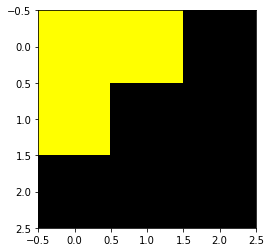

In [19]:
for i in range(fl_filter_count):
    plt.imshow(first_layer_kernel[:,:,:,i])
    plt.show()
    t = first_layer_kernel[:,:,:,i] / first_layer_kernel.max() * 255
    t = cv2.cvtColor(t.astype(np.uint8), cv2.COLOR_RGB2BGR)
    cv2.imwrite("edge_{}.png".format(i), t)

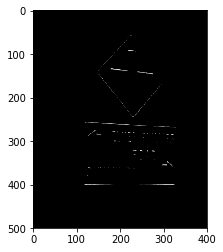

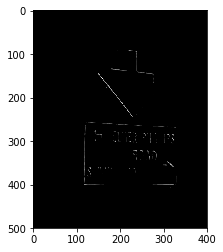

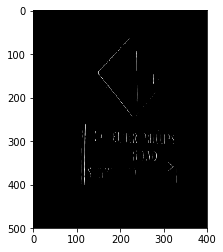

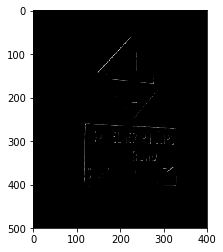

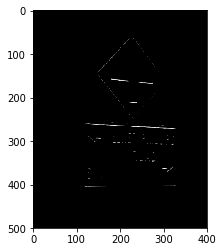

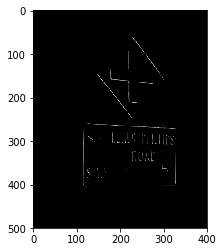

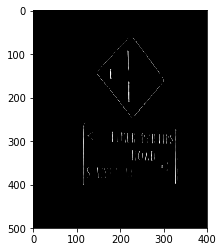

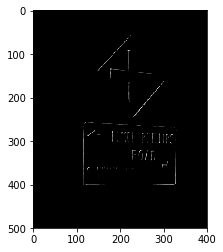

In [15]:
for i in range(fl_filter_count):
#     for j in range(fl_input_filters):
#         print(first_layer_kernel[:,:,j,i].reshape(fl_kernel_size,fl_kernel_size))
#     plt.imshow(first_layer_kernel[:,:,:,i])
#     plt.show()
    plt.imshow(results[0, :, :, i], cmap='gray')
    plt.show()
    cv2.imwrite("edge_res_{}.png".format(i), results[0, :, :, i])

In [8]:
def line_detection_filter(filter_size, line_length, line_offset, line_angle) -> np.ndarray:
    filter_matrix = np.zeros(shape=(filter_size, filter_size), dtype=np.float32)
    center = filter_size // 2
    x_lenght = abs(round(line_length * math.cos(line_angle)))
    line_middle_x = round(-line_offset * math.sin(line_angle))
    if x_lenght <= 1:
        p1_max = min(filter_size, center + line_length + 1)
        p2_max = min(filter_size, center + line_length//2 + 1)
        p3_max = max(0, center - line_length//2)
        p3_min = max(0, center - line_length)
        x_pos = max(0, min(filter_size - 1, center + line_middle_x))
        filter_matrix[p2_max:p1_max, x_pos] = -1.
        filter_matrix[p3_max:p2_max, x_pos] = 1.
        filter_matrix[p3_min:p3_max, x_pos] = -1.
        return filter_matrix
    a = math.tan(line_angle)
    b = line_offset * math.cos(line_angle) - a * line_middle_x
    def f(x:int):
        point_list_x = []
        point_list_y = []
        if -center <= x <= center:
            v_start = round(a * (x-0.5) + b)
            v_end = round(a * (x+0.5) + b)
            v_min = min(v_start, v_end)
            v_max = max(v_start, v_end)
            if v_min == v_max:
                v_max += 1
            for v in range(max(-center, v_min), min(center + 1, v_max)):
                point_list_x.append(x + center)
                point_list_y.append(v + center)
        return point_list_y, point_list_x
    for x in range(line_middle_x - x_lenght, 
                   line_middle_x - x_lenght//2):
        filter_matrix[f(x)] = -1.
    for x in range(line_middle_x - x_lenght//2, 
                   line_middle_x + 1 + x_lenght//2):
        filter_matrix[f(x)] = 1.
    for x in range(line_middle_x + 1 + x_lenght//2, 
                   line_middle_x + 1 + x_lenght):
        filter_matrix[f(x)] = -1.
    return filter_matrix

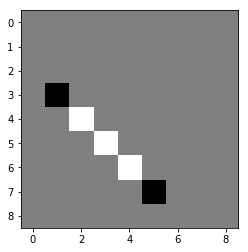

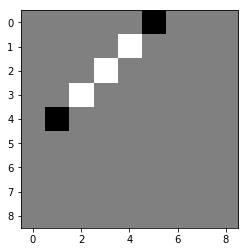

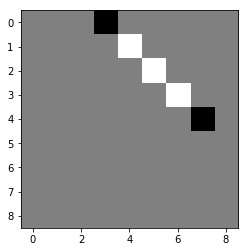

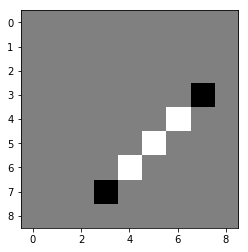

In [9]:
for i in range(4):
    r = line_detection_filter(9, 3, 1.5, math.pi * (2*i+1) / 4)
#     print(r)
    plt.imshow(r, cmap='gray', vmin=-1, vmax=1)
    plt.show()

In [10]:
sl_filter_count = 1
sl_min_size = 5
sl_max_size = 5
sl_filter_size = 11

sl_kernel = np.zeros(shape=(sl_filter_size, sl_filter_size, fl_filter_count, sl_filter_count))
sl_bias = np.zeros(shape=sl_filter_count)

for f in range(sl_filter_count):
    square_size = f * (sl_max_size - sl_min_size) + sl_min_size
    for i in range(1, fl_filter_count, 2):
        angle = i * math.pi * 2 / fl_filter_count
        sl_kernel[:, :, i, f] = line_detection_filter(sl_filter_size, 
                                                      square_size, 
                                                      square_size//2, 
                                                      angle)

In [11]:
inp = Input(shape=(None,None,fl_input_filters))
layer1 = Convolution2D(fl_filter_count, 
                       fl_kernel_size, 
                       fl_kernel_size, 
                       border_mode='valid', 
                       init='normal',
                       bias=True,
                       activation='relu')(inp)
layer2 = Convolution2D(sl_filter_count, 
                       sl_filter_size, 
                       sl_filter_size, 
                       border_mode='valid', 
                       init='normal',
                       bias=True,
                       activation='relu')(layer1)
model_network = Model(input=inp, output=layer2)

model_network.layers[1].set_weights((first_layer_kernel, first_layer_bias))
model_network.layers[2].set_weights((sl_kernel, sl_bias))

/home/nicolas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), activation="relu", padding="valid", kernel_initializer="normal", use_bias=True)`
  
/home/nicolas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (11, 11), activation="relu", padding="valid", kernel_initializer="normal", use_bias=True)`
  from ipykernel import kernelapp as app
/home/nicolas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  app.launch_new_instance()


In [12]:
input_im = im.reshape((1,) + im.shape)
results = model_network.predict(input_im)
print(results.shape)

(1, 1012, 1212, 1)


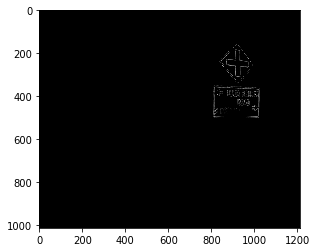

In [13]:
for i in range(sl_filter_count):
    plt.imshow(results[0, :, :, i], cmap='gray')
    plt.show()

In [14]:
def small_filter_line_detector(filter_size: int, line_angle: float):
    filter_matrix = np.zeros(shape=(filter_size, filter_size), dtype=np.float32)
    center = filter_size // 2
    line_middle_x = center
    a = math.tan(line_angle)
    def f(x:int):
        point_list_x = []
        point_list_y = []
        if -center <= x <= center:
            v_start = round(a * (x-0.5))
            v_end = round(a * (x+0.5))
            v_min = min(v_start, v_end)
            v_max = max(v_start, v_end)
            if v_max - v_min == 1 and v_max == round(a * x):
                v_min += 1
                v_max += 1
            elif v_min == v_max:
                v_max += 1
            for v in range(max(-center, v_min), min(center + 1, v_max)):
                point_list_x.append(x + center)
                point_list_y.append(v + center)
        return point_list_y, point_list_x
    for x in range(0, filter_size):
        filter_matrix[f(x - center)] = 1.
    return filter_matrix / filter_matrix.sum()

In [15]:
dim_redu_filter_count = fl_filter_count
dim_redu_angle_increment = fl_angle_increment
dim_redu_filter_size = 5

dim_redu_kernel = np.zeros(shape=(dim_redu_filter_size, 
                                  dim_redu_filter_size, 
                                  dim_redu_filter_count, 
                                  dim_redu_filter_count))
dim_redu_bias = np.zeros(shape=dim_redu_filter_count)

for f in range(dim_redu_filter_count):
    angle = f * dim_redu_angle_increment
    dim_redu_kernel[:,:,f,f] = small_filter_line_detector(dim_redu_filter_size,
                                                          angle)


In [41]:
square_detection_layer_filter_count = 1
square_detection_layer_min_size = 5
square_detection_layer_max_size = 5
square_detection_layer_filter_size = 11

square_detection_layer_kernel = np.zeros(shape=(square_detection_layer_filter_size, 
                                                        square_detection_layer_filter_size, 
                                                        square_detection_layer_filter_count, 
                                                        square_detection_layer_filter_count))
square_detection_layer_kernel_bias = np.zeros(shape=square_detection_layer_filter_count)

for f in range(square_detection_layer_filter_count):
    square_size = f * (square_detection_layer_max_size - square_detection_layer_min_size) \
                    + square_detection_layer_min_size
    for i in range(1, fl_filter_count, 2):
        angle = i * math.pi * 2 / square_detection_layer_filter_count
        square_detection_layer_kernel[:, :, i, f] = line_detection_filter(square_detection_layer_filter_size, 
                                                                          square_size, 
                                                                          square_size//2, 
                                                                          angle)

IndexError: index 1 is out of bounds for axis 2 with size 1

In [35]:
inp = Input(shape=(None,None,fl_input_filters))
layer1 = Conv2D(fl_filter_count, 
                       fl_kernel_size, 
                       fl_kernel_size, 
                       border_mode='valid', 
                       init='normal',
                       bias=True,
                       activation='relu')
dim_redu_layer = Conv2D(dim_redu_filter_count, 
                               dim_redu_filter_size, 
                               dim_redu_filter_size, 
                               border_mode='valid', 
                               init='normal',
                               bias=True,
                               activation='relu')
max_pool_layer = MaxPool2D(pool_size=(2, 2), padding='valid')
square_detection_layer = Conv2D(square_detection_layer_f)

out = layer1(inp)
for i in range(5):
    out = dim_redu_layer(out)
    out = max_pool_layer(out)

model_network = Model(input=inp, output=out)

model_network.layers[1].set_weights((first_layer_kernel, first_layer_bias))
model_network.layers[2].set_weights((dim_redu_kernel, dim_redu_bias))

/home/nicolas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), activation="relu", padding="valid", kernel_initializer="normal", use_bias=True)`
  
/home/nicolas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (5, 5), activation="relu", padding="valid", kernel_initializer="normal", use_bias=True)`
  from ipykernel import kernelapp as app
/home/nicolas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ma...)`


In [36]:
input_im = im.reshape((1,) + im.shape)
results = model_network.predict(input_im)
print(results.shape)

(1, 28, 34, 8)


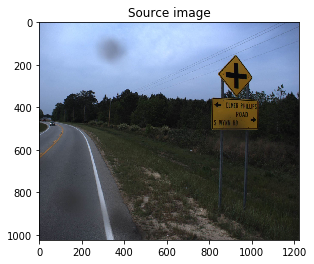

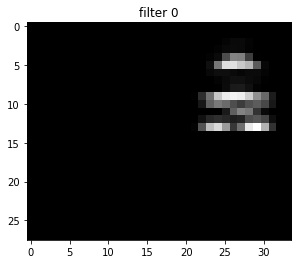

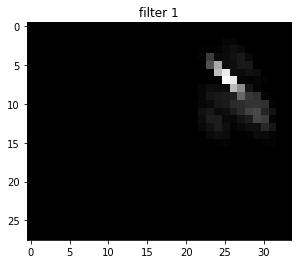

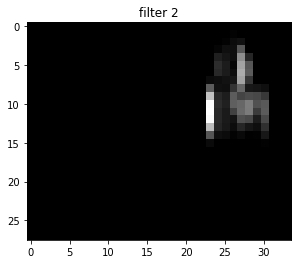

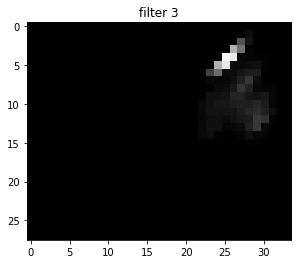

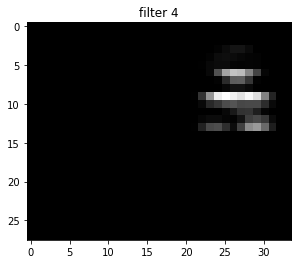

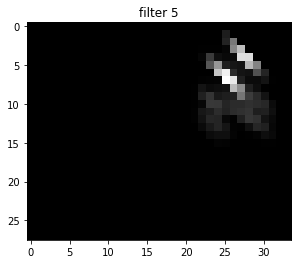

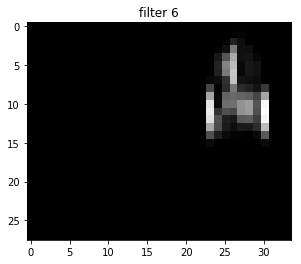

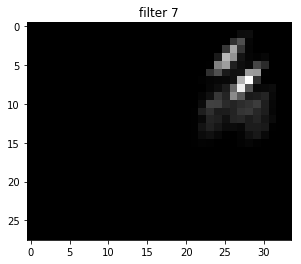

In [37]:
plt.imshow(im)
plt.title("Source image")
plt.show()
for i in range(results.shape[-1]):
    plt.imshow(results[0, :, :, i], cmap='gray')
    plt.title("filter {}".format(i))
    plt.show()
